# 🗒️Table of Contents
1. Introduction
2. Descriptive Analysis
3. GARCH modeling
4. Backtesting
5. VaR estimation
6. References

# Introduction 1.0
The analysis covers the applications of time series analysis tools on the BSESN data. Prices are imported directly from Yahoo Finance via the "quantmod" package. The main purpose is to use GARCH model to deal with volatility clustering; in particular, sGARCH and eGARCH specifications with different conditional error distribution are used. Once the models are fitted, the goal is to select the best one to estimate Value at Risk, therefore backtesting procedures are performed (Kupiec and Christoffersen tests). Finally, 1-step ahead VaR forecast is computed with the model that outperforms the others in the backtesting procedures.

> **📌The following function allows to install packages (link in the references)**

In [1]:
packages <-   base::list('rugarch','e1071','caret')

# Function of packages checking:
pack <- function(pkg) {
  old_pkg <- packages[!(packages %in% installed.packages()[, "Package"])]
  for (i in old_pkg) {
      sapply(i, install.packages)
  }
  for (j in packages) {
      sapply(j, require, character.only = TRUE)
  }
  new_pkg <- packages[(packages %in% installed.packages()[, "Package"])]
 
    if (length(new_pkg) == length(packages)){
    print("All Packages are Loaded Successfully")
  } else {
    print("Please check pack (Not All Packages are loaded)")
  }
    }

# Execute the function:
pack(packages)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘misc3d’, ‘multicool’, ‘plot3D’, ‘GeneralizedHyperbolic’, ‘ks’, ‘spd’, ‘SkewHyperbolic’


Loading required package: rugarch

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma


Loading required package: e1071

Loading required package: caret

Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress




[1] "All Packages are Loaded Successfully"


Prices are imported by the 'quantmod' package, so this routine is directly usable without loading a new dataset.

In [2]:
# Libraries
library(quantmod)
library(rugarch)
library(moments)
library(tidyverse)
library(tseries)

# Load 'real time' prices for BSESN
data_df <- getSymbols('^BSESN', src='yahoo', auto.assign=F)
dim(data_df)
head(data_df)


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘moments’


The following objects are masked from ‘package:e1071’:

    kurtosis, moment, skewness


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::first()    masks xts::first()
✖ dplyr::lag()      masks stats::lag()
✖ dplyr::last()     masks xts::last()
✖ purrr::lift()     masks caret::lift()
✖ caret::progress() masks httr::progress()
✖ purrr::reduce()   masks rugarch::redu

[1] 4121    6

           BSESN.Open BSESN.High BSESN.Low BSESN.Close BSESN.Volume
2007-01-02   13827.77   13980.54  13797.44    13942.24         9600
2007-01-03   13969.45   14035.67  13897.42    14014.92        11600
2007-01-04   14029.04   14060.35  13850.38    13871.71        14600
2007-01-05   13768.79   13971.82  13763.39    13860.52        13200
2007-01-08   13855.89   13855.89  13599.87    13652.15        11600
2007-01-09   13650.96   13748.42  13493.38    13566.33        36600
           BSESN.Adjusted
2007-01-02       13942.24
2007-01-03       14014.92
2007-01-04       13871.71
2007-01-05       13860.52
2007-01-08       13652.15
2007-01-09       13566.33

In [3]:
# Check the data type of a column using typeof()
data_type <- typeof(data_df$column_name)
cat("Data type of column:", data_type, "\n")


Data type of column: NULL 


In [4]:
data_df=na.omit(data_df)

For calculation purposes, I only keep part of the data.

In [5]:
price <- data_df[,4]
head(price)
names(price) <- "Close"
dim(price)

           BSESN.Close
2007-01-02    13942.24
2007-01-03    14014.92
2007-01-04    13871.71
2007-01-05    13860.52
2007-01-08    13652.15
2007-01-09    13566.33

[1] 4097    1

# Descriptive Analysis 2.0
First of all, let's take a look at the price time series.

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.



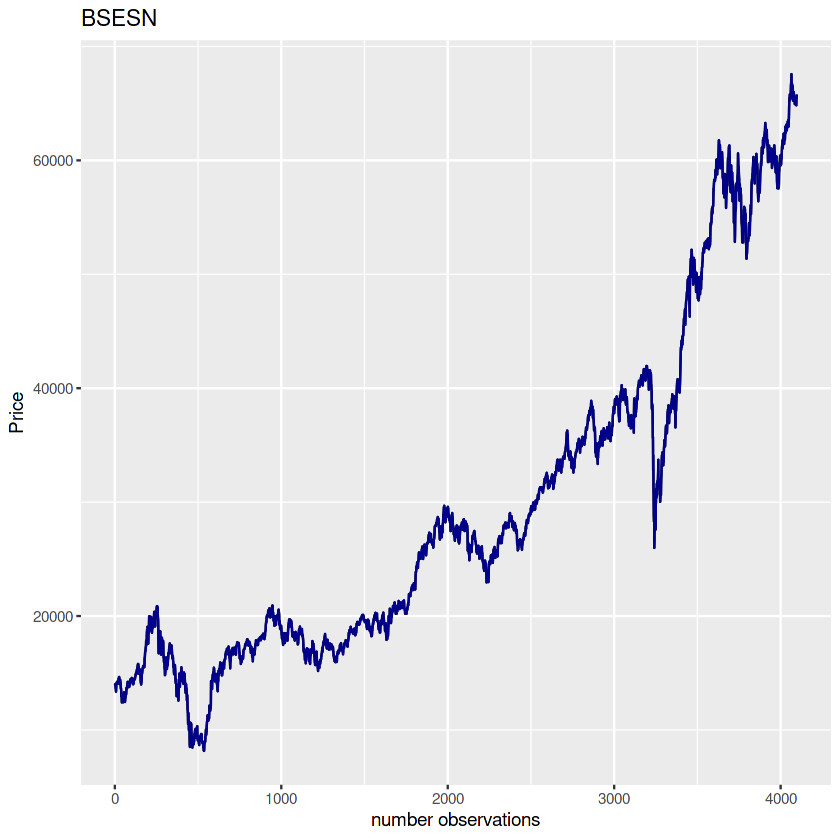

In [6]:
qplot(x=1:length(price), y = price , geom = 'line') + geom_line(color = 'darkblue') + 
    labs(x='number observations',y = 'Price' , title = "BSESN")

In [7]:
summary(price)

     Index                Close      
 Min.   :2007-01-02   Min.   : 8160  
 1st Qu.:2011-03-03   1st Qu.:17749  
 Median :2015-05-15   Median :26272  
 Mean   :2015-05-08   Mean   :29534  
 3rd Qu.:2019-07-12   3rd Qu.:37319  
 Max.   :2023-09-05   Max.   :67572  

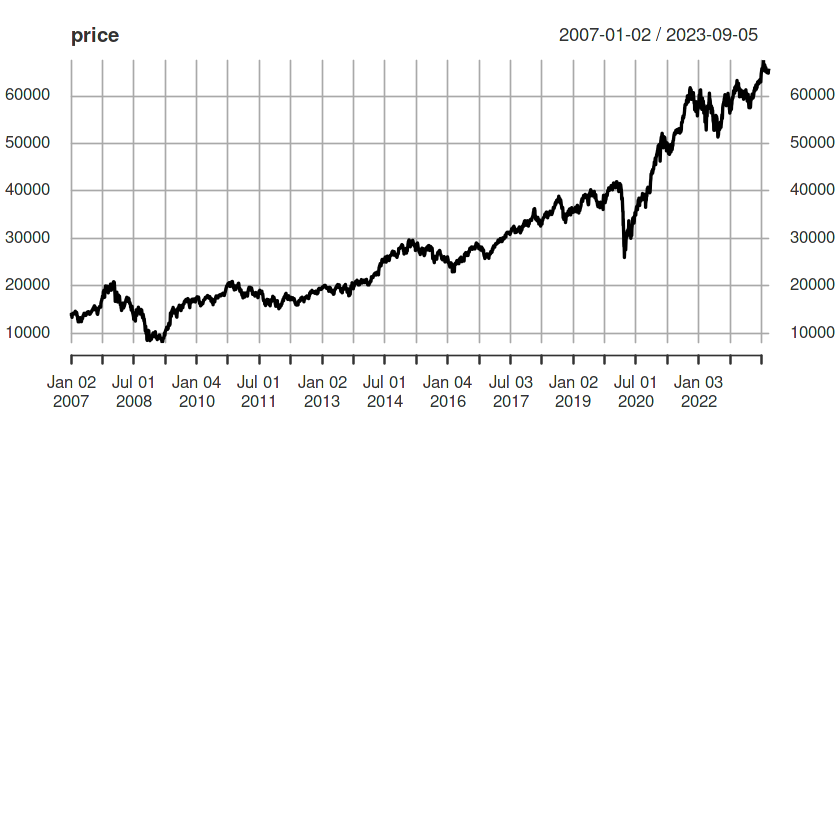

In [8]:
par(mfrow=c(2,1))
plot(price) #Volatility clustering is clearly shown
#acf(returns)
#plot(returns^2)
#acf(returns^2)

Processes need to be stationary, so let's work with returns rather than prices. As can be seen from the Jarque-Bera test, the returns are not normally distributed. In fact, most of the times a simple delta-norm model is not the best choice for financial data. Augmented Dickey-Fuller test is also performed, which confirms the stationarity of returns.

In [9]:
returns <- diff(log(price))
returns <- na.omit(returns)
kurt = kurtosis(returns)
skew = skewness(returns)
mean = mean(returns)
sd = sd(returns)
jarque.bera.test(returns)
adf.test(returns)


	Jarque Bera Test

data:  returns
X-squared = 27959, df = 2, p-value < 2.2e-16


Warning message in adf.test(returns):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  returns
Dickey-Fuller = -14.998, Lag order = 15, p-value = 0.01
alternative hypothesis: stationary


In [10]:
head(returns)

                   Close
2007-01-03  0.0051993730
2007-01-04 -0.0102709593
2007-01-05 -0.0008070343
2007-01-08 -0.0151474302
2007-01-09 -0.0063060535
2007-01-10 -0.0151641501

In [11]:
actual_volatility=sd(returns)

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.



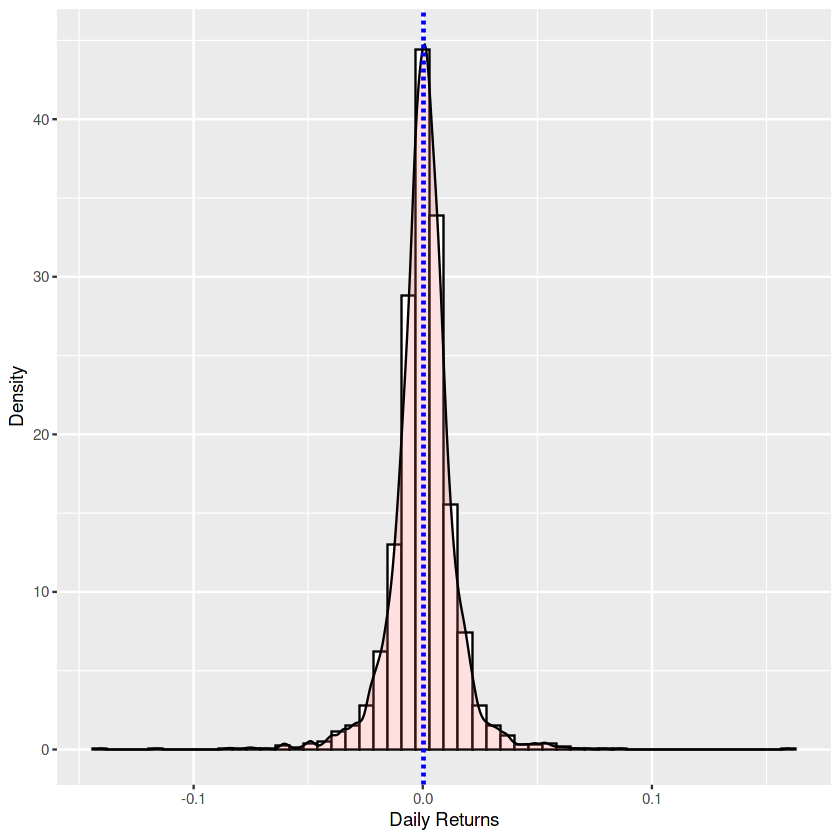

In [12]:
ggplot(returns, aes(x=returns)) + 
   geom_histogram(aes(y=..density..), colour="black", fill="white", bins = 50)+
   geom_density(alpha=.2, fill="#FF6666")+
   geom_vline(aes(xintercept=mean(returns)),
              color="blue", linetype="dashed", size=1)+
   labs(x='Daily Returns',y='Density')

In order to model a time series, past information is used to predict the variable of interest. Looking at the ACF of the returns, it is clear that it behaves like white noise, which means that it is impossible to model returns directly. However, since returns have mean approximately equal to zero, you can work with squared returns to model volatility. 

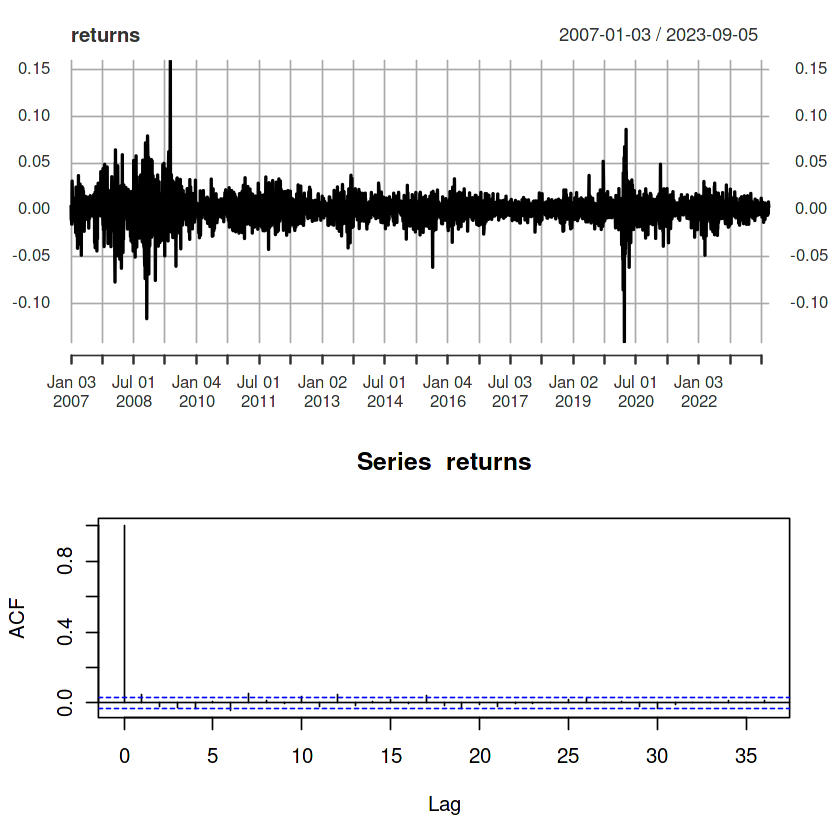

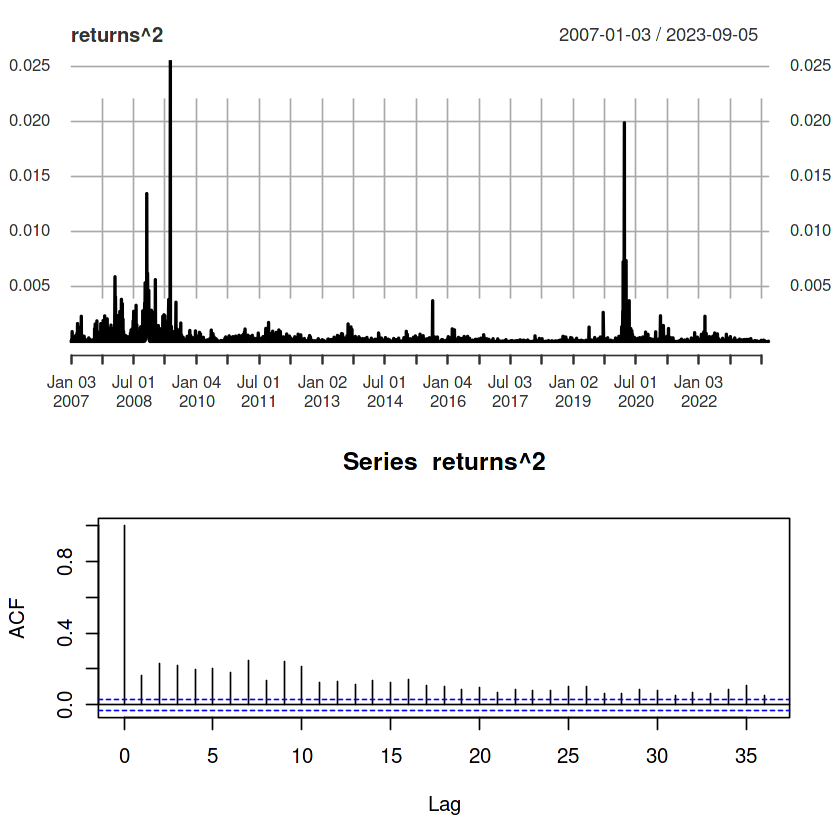

In [13]:
par(mfrow=c(2,1))
plot(returns) #Volatility clustering is clearly shown
acf(returns)
plot(returns^2)
acf(returns^2)

# GARCH modeling 3.0
Let's define all the different specifications. I use sGARCH and eGARCH with the following conditional error distribution:
* norm
* std
* snorm
* sstd

In [14]:
mod_spec1 = ugarchspec(variance.model=list(model="sGARCH", garchOrder=c(1,1)), 
                      mean.model=list(armaOrder=c(0,0)),  
                      distribution.model="norm")
mod_spec2 = ugarchspec(variance.model=list(model="sGARCH", garchOrder=c(1,1)), 
                       mean.model=list(armaOrder=c(0,0)),  
                       distribution.model="std")
mod_spec3 = ugarchspec(variance.model=list(model="sGARCH", garchOrder=c(1,1)), 
                       mean.model=list(armaOrder=c(0,0)),  
                       distribution.model="snorm")
mod_spec4 = ugarchspec(variance.model=list(model="sGARCH", garchOrder=c(1,1)), 
                       mean.model=list(armaOrder=c(0,0)),  
                       distribution.model="sstd")
mod_spec5 = ugarchspec(variance.model=list(model="eGARCH", garchOrder=c(1,1)), 
                      mean.model=list(armaOrder=c(0,0)),  
                      distribution.model="norm")
mod_spec6 = ugarchspec(variance.model=list(model="eGARCH", garchOrder=c(1,1)), 
                       mean.model=list(armaOrder=c(0,0)),  
                       distribution.model="std")
mod_spec7 = ugarchspec(variance.model=list(model="eGARCH", garchOrder=c(1,1)), 
                       mean.model=list(armaOrder=c(0,0)),  
                       distribution.model="snorm")
mod_spec8 = ugarchspec(variance.model=list(model="eGARCH", garchOrder=c(1,1)), 
                       mean.model=list(armaOrder=c(0,0)),  
                       distribution.model="sstd")

BSESN_fit1 = ugarchfit(data=returns, spec=mod_spec1)
BSESN_fit2 = ugarchfit(data=returns, spec=mod_spec2)
BSESN_fit3 = ugarchfit(data=returns, spec=mod_spec3)
BSESN_fit4 = ugarchfit(data=returns, spec=mod_spec4)
BSESN_fit5 = ugarchfit(data=returns, spec=mod_spec5)
BSESN_fit6 = ugarchfit(data=returns, spec=mod_spec6)
BSESN_fit7 = ugarchfit(data=returns, spec=mod_spec7)
BSESN_fit8 = ugarchfit(data=returns, spec=mod_spec8)

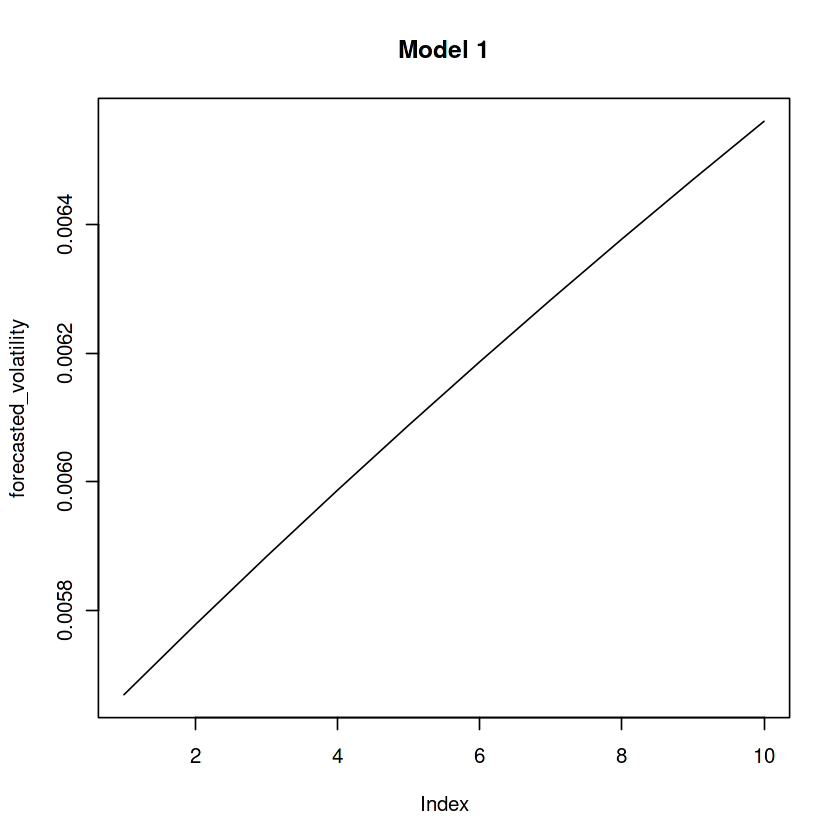

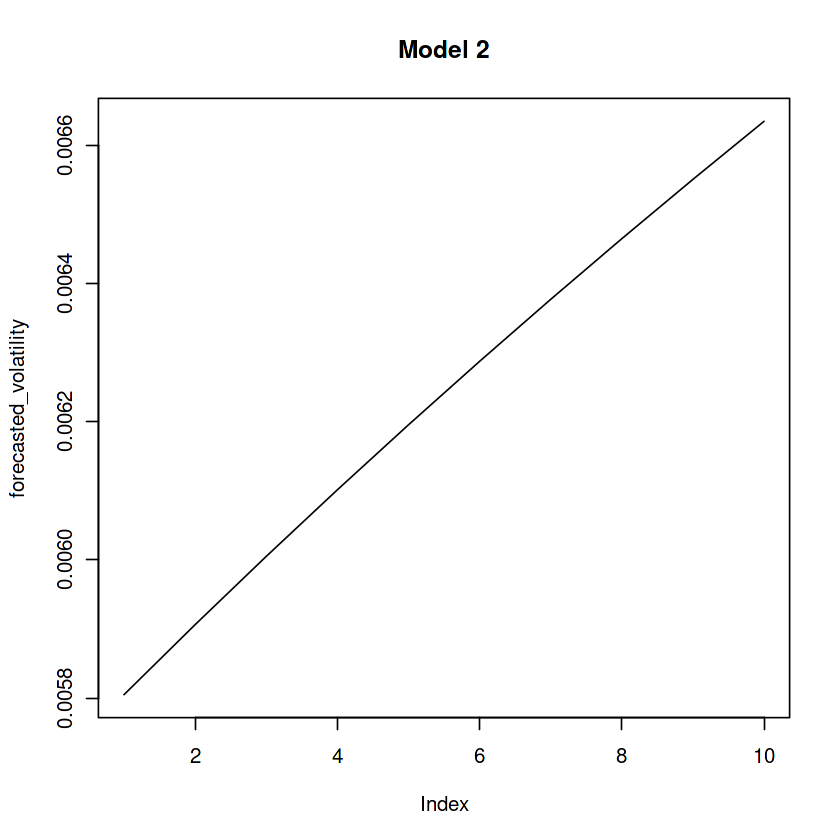

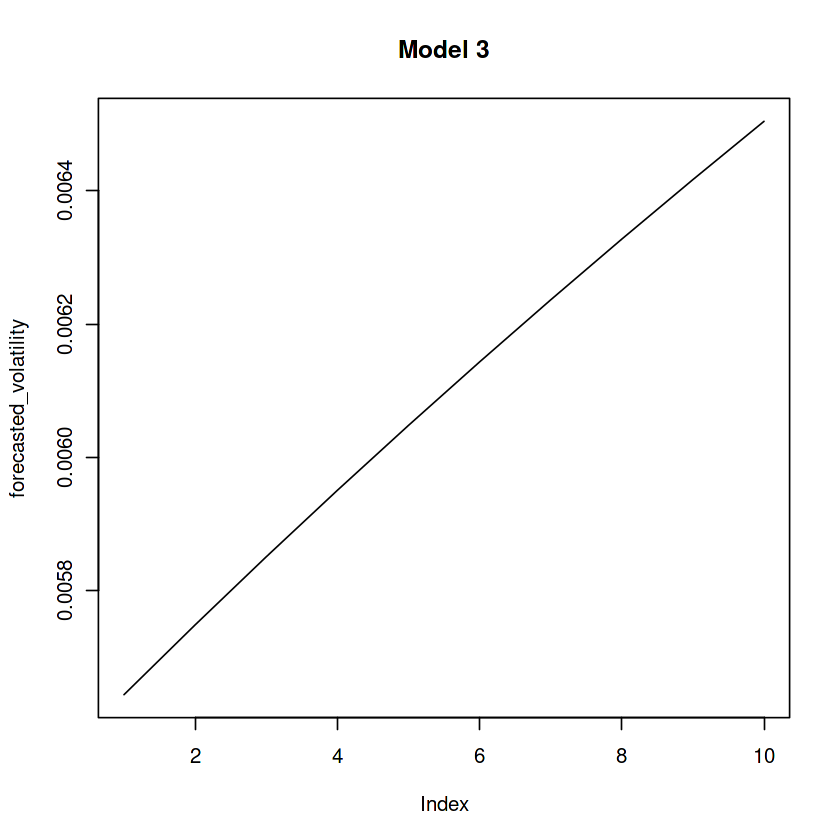

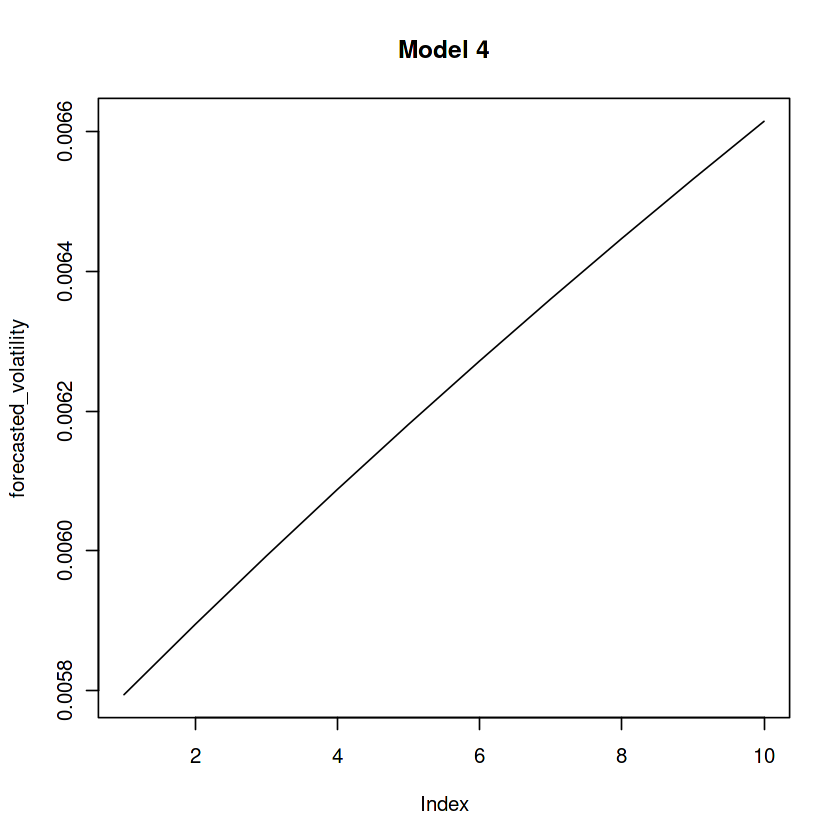

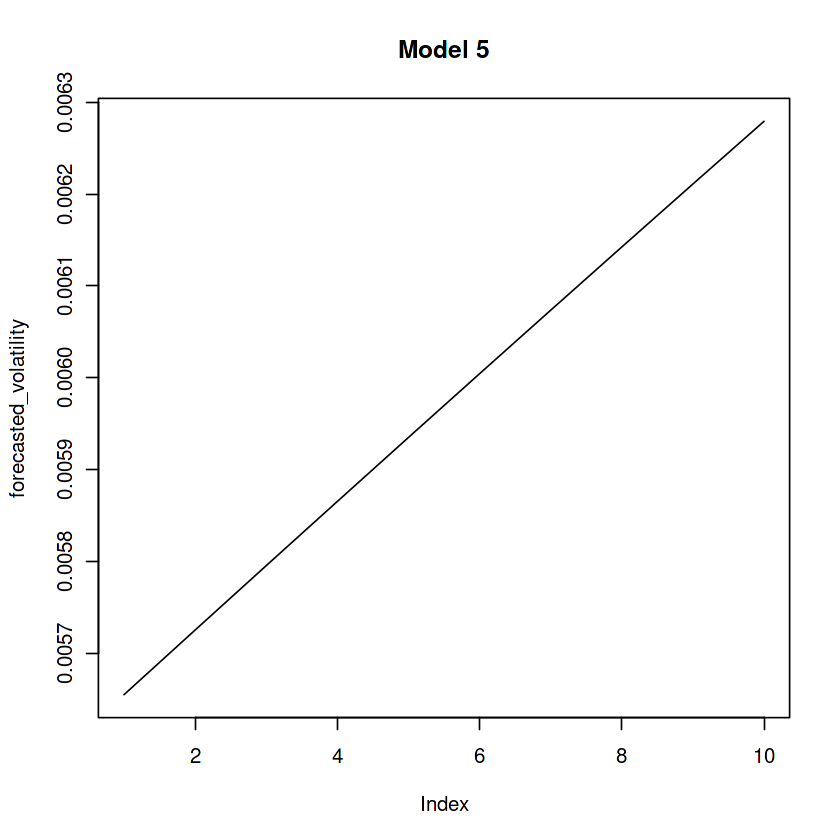

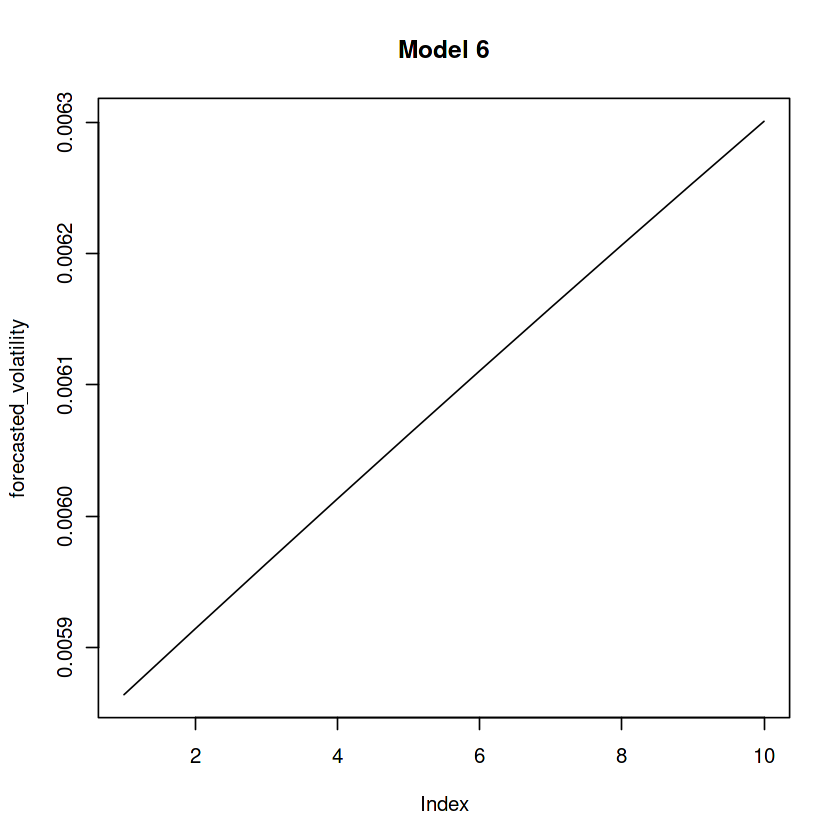

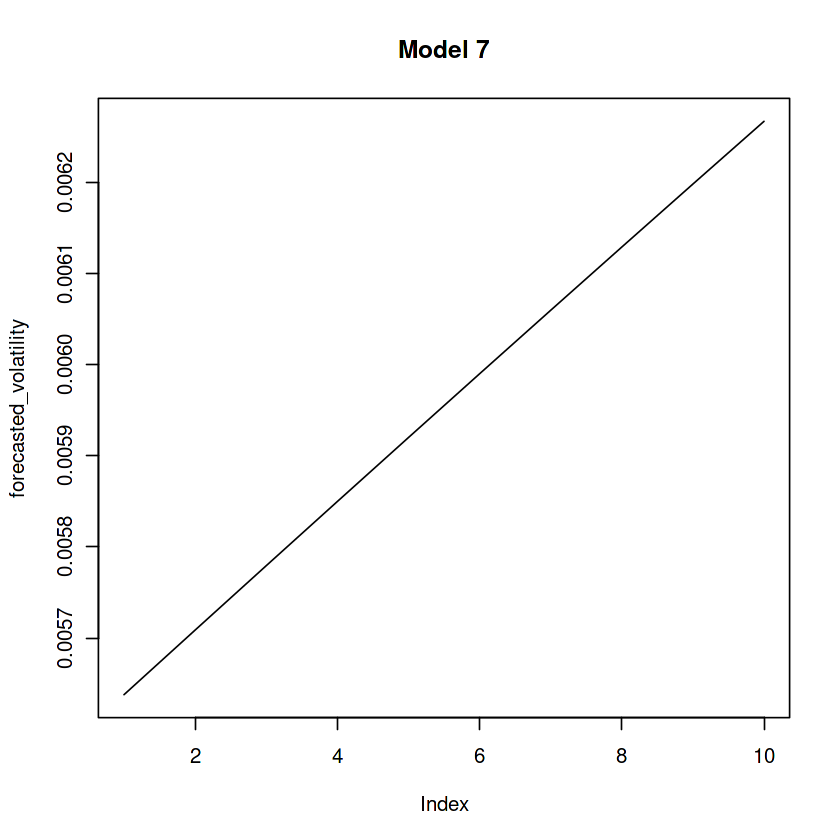

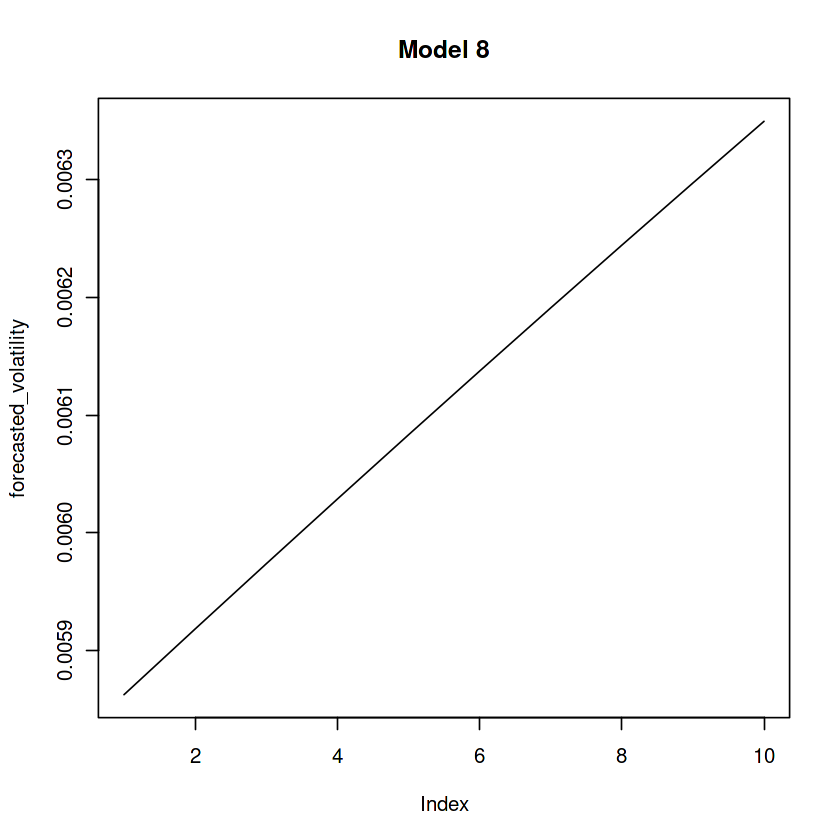

In [16]:
# Assuming you've already fitted the models as mentioned in your original code

# Create a list of fitted models
fitted_models <- list(BSESN_fit1, BSESN_fit2, BSESN_fit3, BSESN_fit4, BSESN_fit5, BSESN_fit6, BSESN_fit7, BSESN_fit8)

# Create a vector of model names for labeling plots
model_names <- c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6", "Model 7", "Model 8")

# Number of periods ahead to forecast
n.ahead <- 10  # Change as needed

# Create a loop to generate and plot forecasts for each model
for (i in 1:length(fitted_models)) {
  model <- fitted_models[[i]]
  model_name <- model_names[i]

  # Generate forecasts for the model
  forecasts <- ugarchforecast(model, n.ahead = n.ahead)

  # Extract the forecasted volatility
  forecasted_volatility <- sigma(forecasts)

  # Plot the forecasted volatility
  plot(forecasted_volatility, type = "l", main = model_name)
}


[1] "Diagnostics for Model 1"

*------------------------------------*
*    GARCH Parameter Distribution    *
*------------------------------------*
Model : sGARCH
No. Paths (m.sim) : 100
Length of Paths (n.sim) : 2000
Recursive : FALSE

Coefficients: True vs Simulation Mean (Window-n)
                    mu      omega   alpha1   beta1
true-coef   0.00075166 1.4465e-06 0.092099 0.90158
window-2000 0.00078146 1.8644e-06 0.092939 0.89756




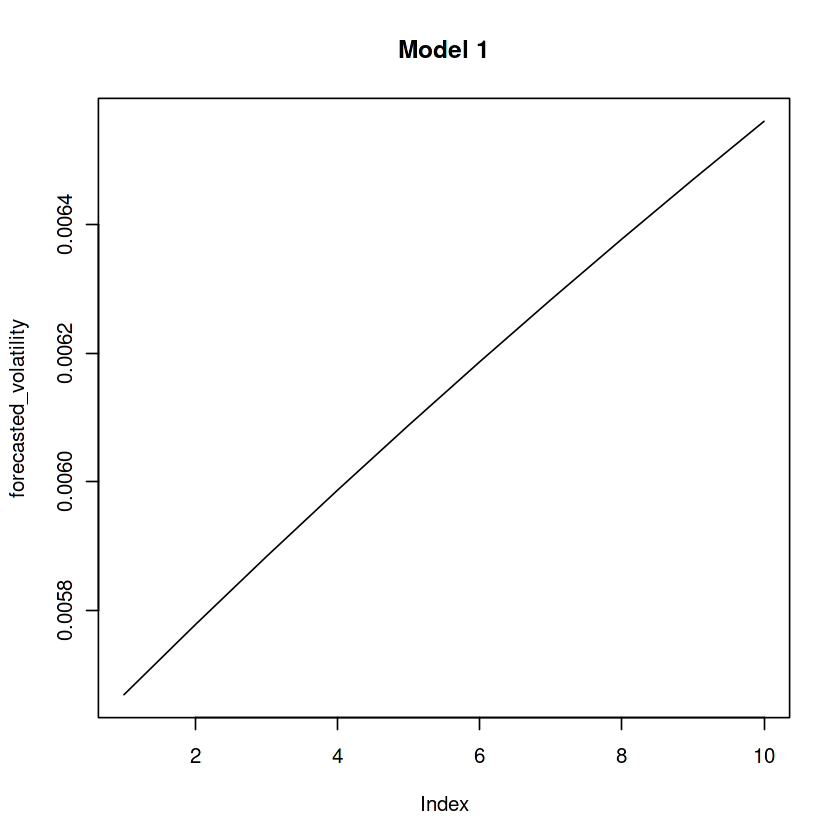

[1] "Diagnostics for Model 2"

*------------------------------------*
*    GARCH Parameter Distribution    *
*------------------------------------*
Model : sGARCH
No. Paths (m.sim) : 100
Length of Paths (n.sim) : 2000
Recursive : FALSE

Coefficients: True vs Simulation Mean (Window-n)
                    mu      omega   alpha1   beta1  shape
true-coef   0.00076900 1.4757e-06 0.081736 0.90973 7.3193
window-2000 0.00076263 1.7918e-06 0.082136 0.90677 7.4849




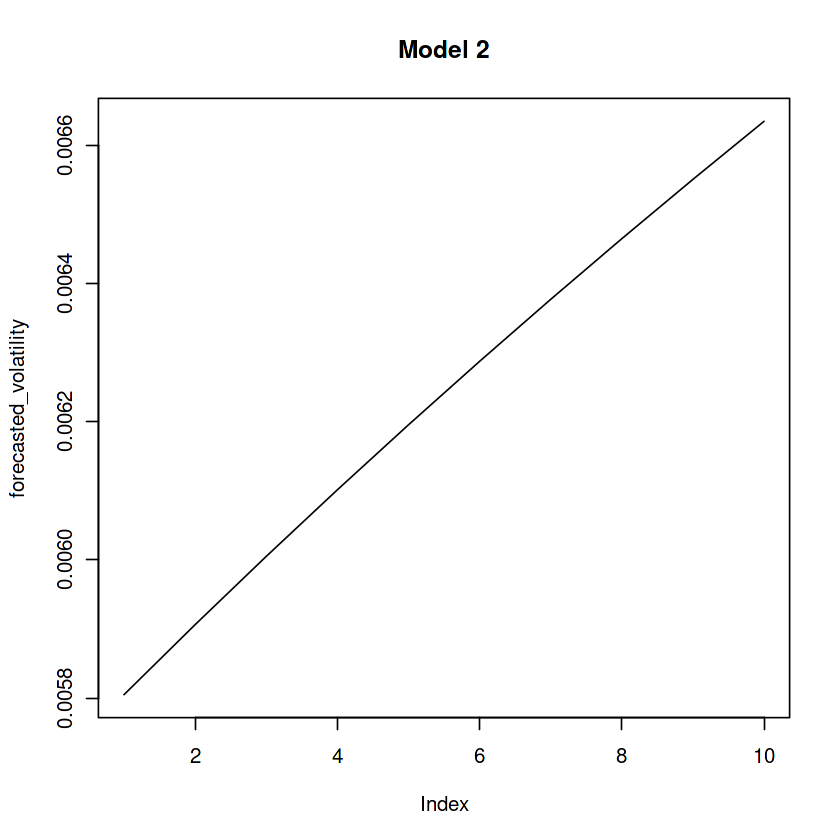

[1] "Diagnostics for Model 3"

*------------------------------------*
*    GARCH Parameter Distribution    *
*------------------------------------*
Model : sGARCH
No. Paths (m.sim) : 100
Length of Paths (n.sim) : 2000
Recursive : FALSE

Coefficients: True vs Simulation Mean (Window-n)
                    mu      omega   alpha1   beta1    skew
true-coef   0.00069721 1.4079e-06 0.090585 0.90265 0.92492
window-2000 0.00067124 1.7655e-06 0.092137 0.89882 0.92754




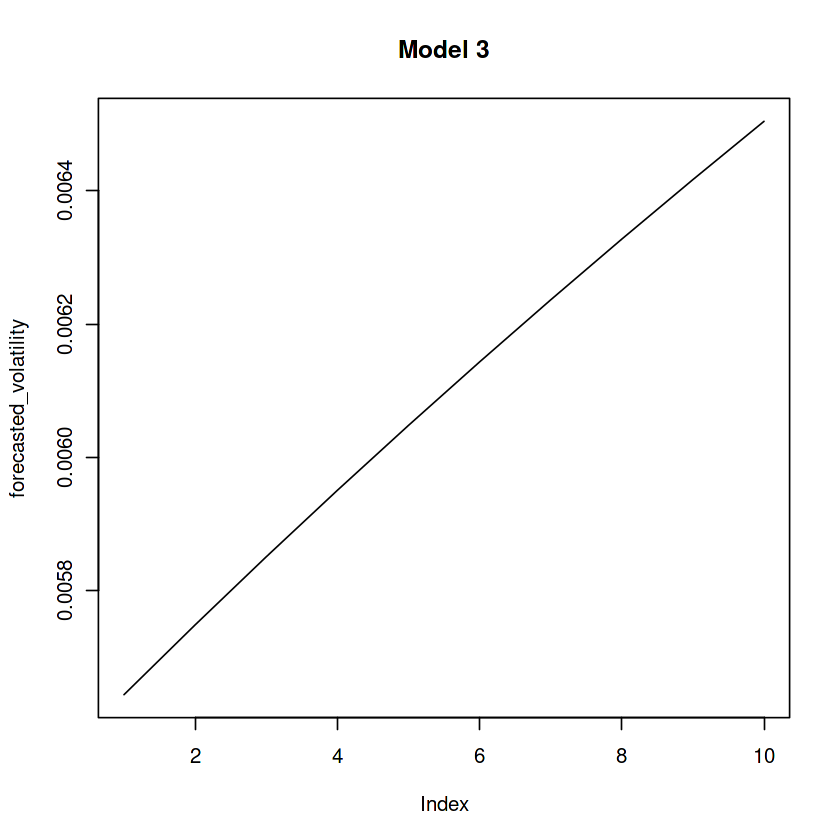

[1] "Diagnostics for Model 4"

*------------------------------------*
*    GARCH Parameter Distribution    *
*------------------------------------*
Model : sGARCH
No. Paths (m.sim) : 100
Length of Paths (n.sim) : 2000
Recursive : FALSE

Coefficients: True vs Simulation Mean (Window-n)
                    mu      omega   alpha1   beta1    skew  shape
true-coef   0.00064256 1.4868e-06 0.081251 0.90945 0.92989 7.5559
window-2000 0.00064168 1.7401e-06 0.084437 0.90464 0.92508 7.8332




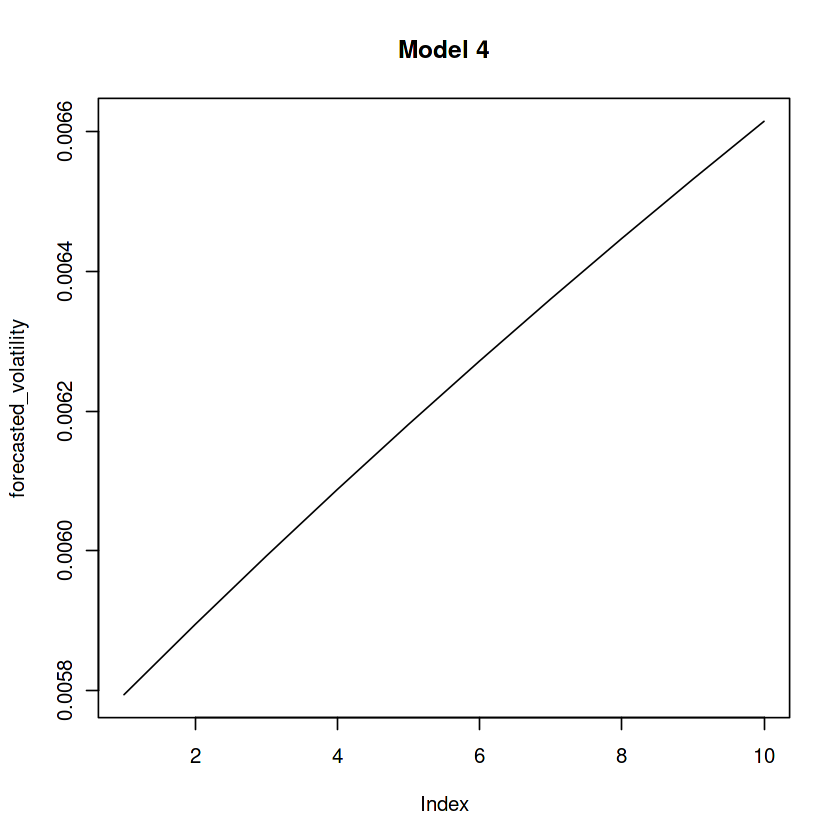

[1] "Diagnostics for Model 5"

*------------------------------------*
*    GARCH Parameter Distribution    *
*------------------------------------*
Model : eGARCH
No. Paths (m.sim) : 100
Length of Paths (n.sim) : 2000
Recursive : FALSE

Coefficients: True vs Simulation Mean (Window-n)
                    mu    omega    alpha1   beta1  gamma1
true-coef   0.00042637 -0.13370 -0.083133 0.98469 0.17520
window-2000 0.00038354 -0.14898 -0.085078 0.98298 0.16951




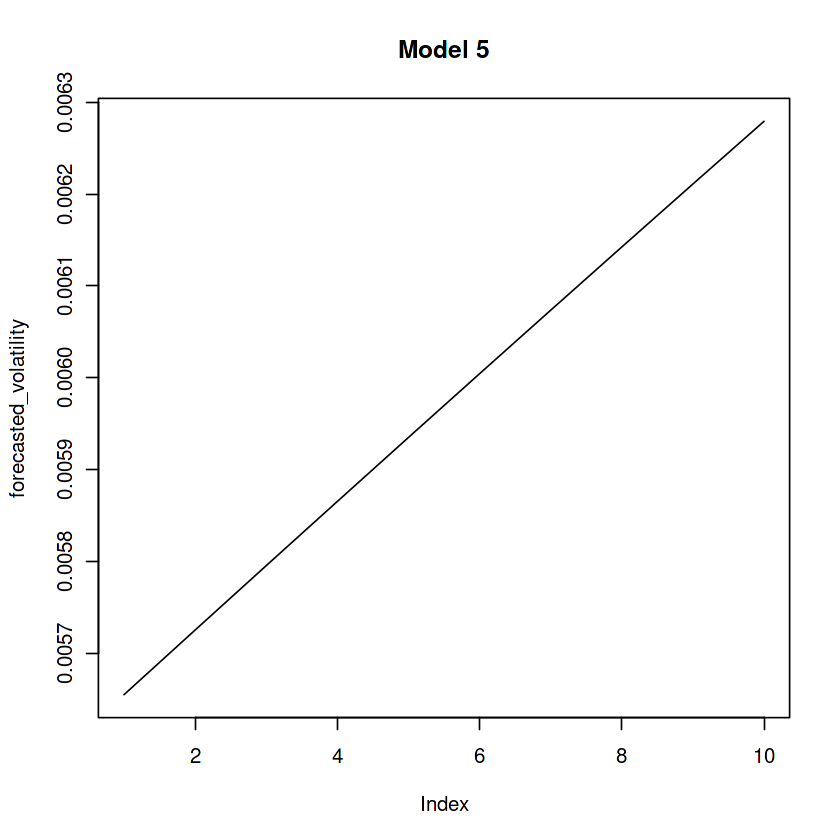

In [17]:
# Assuming you've already fitted the models as mentioned in your original code

# Create a list of fitted models
fitted_models <- list(BSESN_fit1, BSESN_fit2, BSESN_fit3, BSESN_fit4, BSESN_fit5, BSESN_fit6, BSESN_fit7, BSESN_fit8)

# Create a vector of model names for labeling plots
model_names <- c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6", "Model 7", "Model 8")

# Number of periods ahead to forecast
n.ahead <- 10  # Change as needed

# Create a loop to generate and plot forecasts for each model
for (i in 1:length(fitted_models)) {
  model <- fitted_models[[i]]
  model_name <- model_names[i]

  # Generate forecasts for the model
  forecasts <- ugarchforecast(model, n.ahead = n.ahead)

  # Extract the forecasted volatility
  forecasted_volatility <- sigma(forecasts)

  # Plot the forecasted volatility
  plot(forecasted_volatility, type = "l", main = model_name)

  # Perform model diagnostics
  diagnostic_summary <- ugarchdistribution(model)
  print(paste("Diagnostics for", model_name))
  print(diagnostic_summary)
}


LSSVM

In [18]:
returnsd <- diff(log(data_df))
returnsd <- na.omit(returnsd)
kurt = kurtosis(returnsd)
skew = skewness(returnsd)
mean = mean(returnsd)
sd = sd(returnsd)
jarque.bera.test(returnsd$BSESN.Close)
adf.test(returnsd$BSESN.Close)


	Jarque Bera Test

data:  returnsd$BSESN.Close
X-squared = 27959, df = 2, p-value < 2.2e-16


Warning message in adf.test(returnsd$BSESN.Close):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  returnsd$BSESN.Close
Dickey-Fuller = -14.998, Lag order = 15, p-value = 0.01
alternative hypothesis: stationary


In [19]:
head(returns)

                   Close
2007-01-03  0.0051993730
2007-01-04 -0.0102709593
2007-01-05 -0.0008070343
2007-01-08 -0.0151474302
2007-01-09 -0.0063060535
2007-01-10 -0.0151641501

In [20]:
# Load required libraries
library(e1071)  # for svm
library(caret)  # for data splitting and model evaluation

# Load or create your dataset, assuming it's in a data frame called 'data_df'
# Your dataset should contain features and the target variable 'BSESN_Price'

# Split the data into training and testing sets
set.seed(123)  # For reproducibility
trainIndex <- createDataPartition(returns, p = 0.8, list = FALSE)
train_data <- returns[trainIndex,]
test_data <- returns[-trainIndex,]

train_data <- na.omit(train_data)
# Train the LS-SVM model
# You may need to tune the hyperparameters (cost, gamma) for your specific dataset
svm_model <- svm(Close ~ ., data = train_data, method = "ls", kernel = "radial", cost = 1, gamma = 0.1)

# Make predictions on the testing data
predictions <- predict(svm_model, test_data)

# Evaluate the model's performance (e.g., using Mean Absolute Error)
mae <- mean(abs(predictions - test_data$Close))/predictions
cat("Mean Absolute Error:", mae, "\n")

# You can also assess the model using other evaluation metrics like RMSE, R-squared, etc.


Mean Absolute Error: 0.02047974 


In [28]:
print(svm_model)


Call:
svm(formula = Close ~ ., data = train_data, method = "ls", kernel = "radial", 
    cost = 1, gamma = 0.1)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.1 
    epsilon:  0.1 


Number of Support Vectors:  2



In [38]:
plot(svm_model,returns)

RMSE is calculated by taking the square root of the mean of the squared differences between the predicted values and the actual values.

R-squared (R^2) is calculated as the proportion of the variance in the dependent variable (Close) that is predictable from the independent variables. It measures the goodness of fit of the model to the data.

These additional calculations provide you with more comprehensive evaluation metrics for your LS-SVM model.

In [37]:
# Evaluate the model's performance (e.g., using Mean Absolute Error)
mae <- mean(abs(predictions - test_data$Close)/predictions)
cat("Mean Absolute Percentage Error:", mae, "\n")


Mean Absolute Percentage Error: -1.105844 


In [21]:
# Calculate Root Mean Squared Error (RMSE)
rmse <- sqrt(mean((predictions - test_data$Close)^2))
cat("Root Mean Squared Error (RMSE):", rmse, "\n")





Root Mean Squared Error (RMSE): 0.02322332 


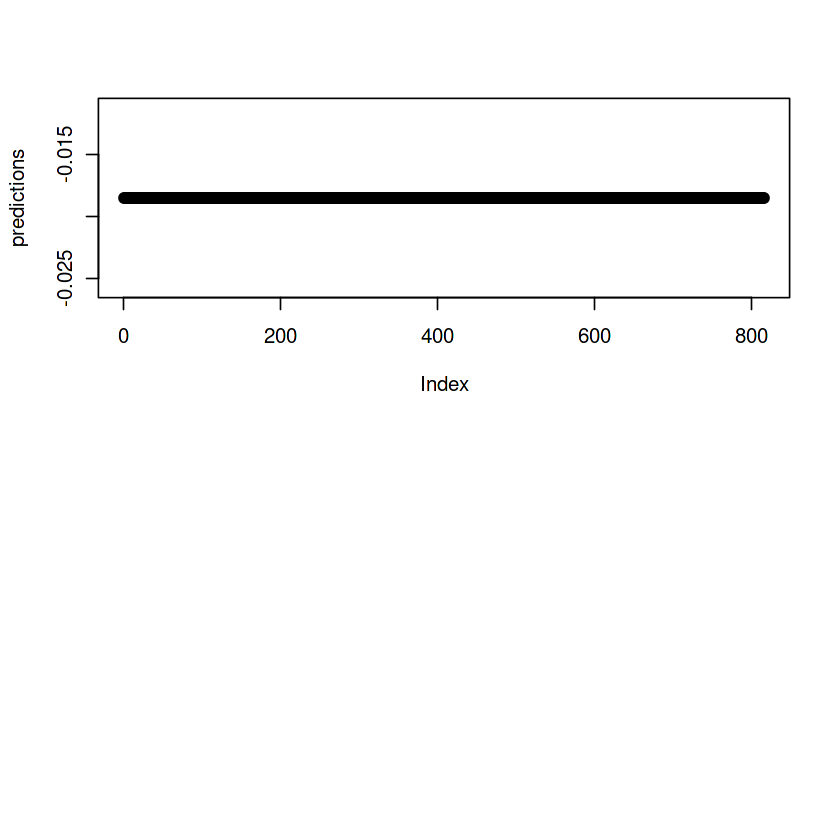

In [22]:
par(mfrow=c(2,1))
plot(predictions)

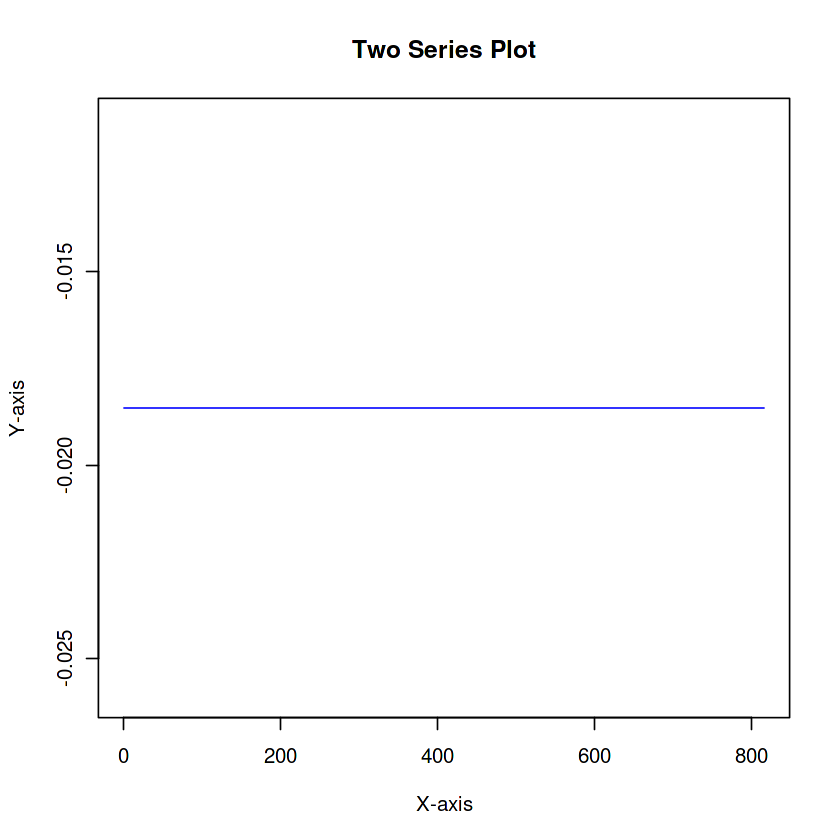

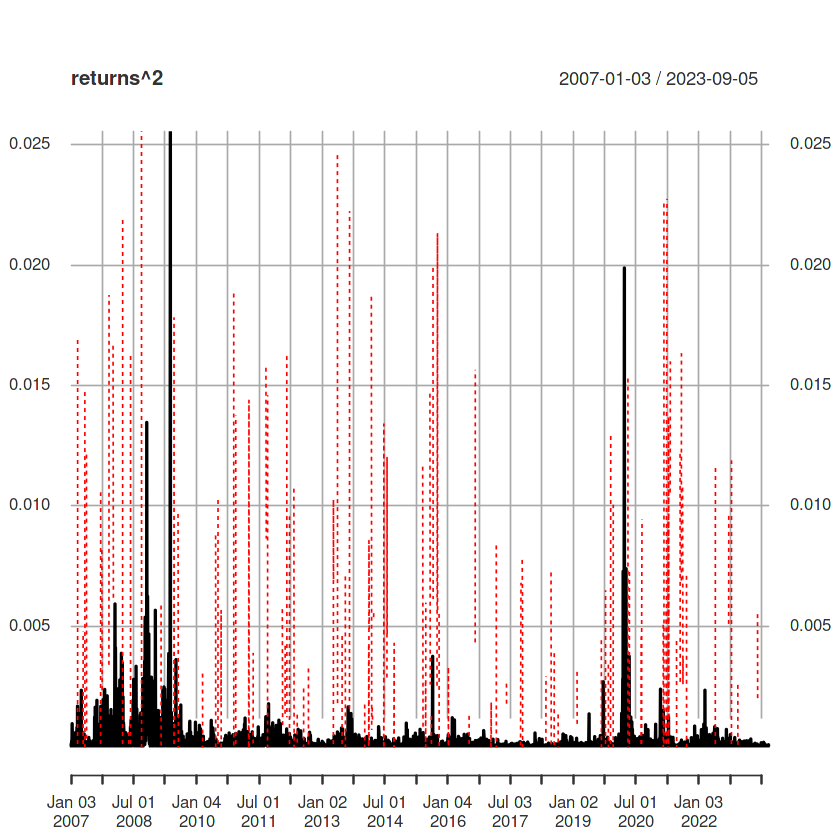

In [23]:
# Create two example datasets

# Plot the first series
plot(predictions, type = "l", col = "blue", lty = 1, xlab = "X-axis", ylab = "Y-axis", main = "Two Series Plot")

# Add the second series to the same plot
lines(test_data, col = "red", lty = 2)

# Add a legend to differentiate the series
legend("topright", legend = c("Predictions", "Test data"), col = c("blue", "red"), lty = c(1, 2))


In [ ]:
# Calculate R-squared (R^2)
ss_res <- sum((test_data$Close - predictions)^2)
ss_tot <- sum((test_data$Close - mean(test_data$Close))^2)
rsquared <- 1 - (ss_res / ss_tot)
cat("R-squared (R^2):", rsquared, "\n")

In [ ]:
head(test_data)

# References
* **https://www.kaggle.com/code/mmedhat101/install-load-all-required-r-packages/notebook**
* **Ghalanos A. (August 2017).** Introduction to the rugarch package (Version 1.3-8).